In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchmin import minimize
import scipy.stats as stats

In [77]:
# SIMULATING THE DATA 

# PARAMETERS
num_patients = 200 # number of patients
patient_affected_prob = 0.6 # probability if patient is affected
mean_test_score = 40 # fixed intercept

noise_var = 0.1  
var_time_effect = 1.0
var_intercept = 1.0  # intercept steht für Ausgangsniveau
var_slope = 0.1 # slope steht für effektstärke / steigung

b_1 = -6.0 # effect of affected family
b_2 = 0.2 # effect of sex 
b_3 = 0.5 # effect of age

# calculating data for num_patients patients 
def simulate_data(num_patients):
    # Generate data
    data = []
    data_we = []

    # simuliere einen Datensatz eines Krankheitsverlauf mit infizierten und gesunden Patienten def simulate_dataset(num_patients):
    for patient_id in range(num_patients):
        # Randomly determine if family is affected
        patient_affected = np.random.choice([0, 1], p=[1-patient_affected_prob, patient_affected_prob])
    
        # Randomly determine sex
        sex = np.random.choice([0, 1], p=[0.5,0.5]) # 50/50 male or women 

        # Randomly determine age
        age = np.random.normal(40,10) # mean_age=40, age_std=10
    
        # Randomly generate time points
        num_time_points = np.random.choice([4,5,6,7,8,9,10])
        time_points = np.sort(np.random.uniform(0, 10, num_time_points))
    
        # Generate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, var_slope)
        time_effects = np.random.normal(0.0, np.sqrt(var_time_effect))
    
        for j,t in enumerate(time_points):
            # Generate noise
            noise = np.random.normal(0.0, np.sqrt(noise_var))
        
            # Simulate test score
            test_score = mean_test_score + random_intercept + b_1 * patient_affected + b_2 * sex + b_3 * age +  time_effects * t + random_slope + noise

            data.append([patient_id, t, patient_affected, sex, age, test_score])
    return data

In [78]:
# return index of first occur of 'pat' in collumn patient_id
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio(Lmin, Lmax, diff):
    return  2 * (Lmax - Lmin)

In [92]:
num_simulations = 100
data = []
for _ in range(num_simulations):
    data.append(pd.DataFrame(simulate_data(200), columns=['patient_id', 'years_after_treatment', 'family_affected', 'sex', 'age', 'test_score']))

In [93]:
#keys for random and fixed effects in the matrix
fixed_effects_keys = ['family_affected', 'sex', 'age']
random_effects_keys = ['years_after_treatment']
#keys for random and fixed effects in the matrix
fixed_effects_keys_r = ['family_affected', 'age']
random_effects_keys_r = ['years_after_treatment']

n_fixed_eff = len(fixed_effects_keys) + 1
n_rand_eff = len(random_effects_keys) + 1
n_fixed_eff_r = len(fixed_effects_keys_r) + 1
n_rand_eff_r = len(random_effects_keys_r) + 1
softplus = torch.nn.Softplus()
D_param = torch.randn(n_rand_eff, requires_grad=True) # Learnable parameter for diagonal covariance matrix
D_param_r = torch.randn(n_rand_eff_r, requires_grad=True) # Learnable parameter for diagonal covariance matrix

lrt_results = []

for i in range(num_simulations):
    N = len(data[i])
    Z_list = calculate_Zlist(data[i], random_effects_keys) # Random effects design matrix (Datenmatrix) for each patient
    X_list = calculate_Xlist(data[i], fixed_effects_keys) # Fixed effects design matrix (Datenmatrix) for each patient
    y = torch.from_numpy(np.array(data[i]['test_score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e = torch.cat([torch.cat((y[get_ind(pat,data[i])], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in data[i]['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_full(D_param): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        return - likelihood
    
    result_full = minimize(calculate_likelihood_full, D_param, method='bfgs', max_iter=6)
    Lmax = result_full.fun

    N_r = len(data[i])
    Z_list_r = calculate_Zlist(data[i], random_effects_keys_r) # Random effects design matrix (Datenmatrix) for each patient
    X_list_r = calculate_Xlist(data[i], fixed_effects_keys_r) # Fixed effects design matrix (Datenmatrix) for each patient
    y_r = torch.from_numpy(np.array(data[i]['test_score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list_r = [torch.cat((X_i, torch.zeros((n_rand_eff_r, n_fixed_eff_r)))) for X_i in X_list_r] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e_r = torch.cat([torch.cat((y_r[get_ind(pat,data[i])], torch.zeros(n_rand_eff_r))).unsqueeze(-1) for pat in data[i]['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_reduced(D_param_r):
        # Ensure that the diagonal covariance matrix has only positive values
        Delta_r = torch.diag(softplus(D_param_r))
        det_Delta_r = torch.det(Delta_r)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list_r = [torch.cat((Z_i, Delta_r)) for Z_i in Z_list_r]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e_r = torch.cat((block_diag_list(Z_tilde_list_r), torch.cat(X_tilde_list_r)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred_r = torch.inverse((X_e_r.t() @ X_e_r)) @ X_e_r.t() @ y_e_r
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma_r = torch.sum((y_e_r - X_e_r @ pred_r) ** 2) / N_r

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N_r/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma_r))
        likelihood += torch.log(torch.stack([det_Delta_r/torch.det(Z_i_tilde_r.t() @ Z_i_tilde_r).sqrt() for Z_i_tilde_r in Z_tilde_list_r])).sum()
        return - likelihood
    result_reduced = minimize(calculate_likelihood_reduced, D_param_r, method='bfgs', max_iter=6)
    Lmin = result_reduced.fun

    lrt_results.append(likelihood_ratio(Lmin,Lmax,1))
    print(i)
    

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: tensor(1429.6294)
        x: tensor([-1.0310, -0.8965])
      nit: 3
     grad: tensor([1.5004, 0.4754])
     nfev: 9
 hess_inv: tensor([[5.0554e-05, 1.6332e-04],
                   [1.6332e-04, 3.8053e-03]])
tensor(1436.0706, grad_fn=<NegBackward0>)
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: tensor(1429.7828)
        x: tensor([-1.0444, -0.8949])
      nit: 6
     grad: tensor([-1.1100,  1.3351])
     nfev: 11
 hess_inv: tensor([[0.0050, 0.0006],
                   [0.0006, 0.0044]])
0
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: tensor(1381.5319)
        x: tensor([-0.9307, -0.9055])
      nit: 5
     grad: tensor([0.2364, 0.0358])
     nfev: 10
 hess_inv: tensor([[0.0053, 0.0009],
                   [0.0009, 0.0044]])
tensor(1391.9917, grad_fn=<NegBackward0>)
  message: Maximum number of iterations has been

In [84]:
lrt_results_500sim = lrt_results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


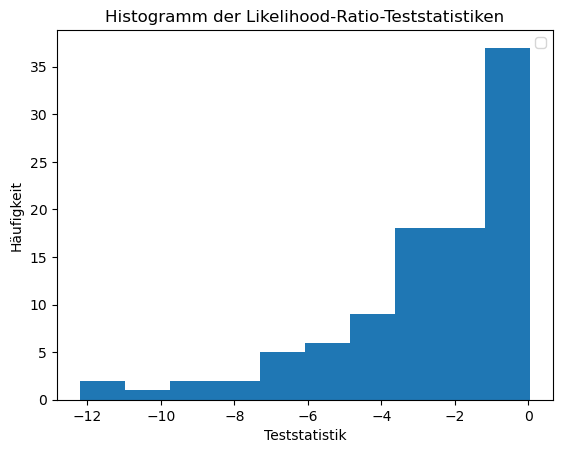

In [94]:
# Histogramm der Teststatistiken erstellen
plt.hist(lrt_results)

# Chi-Quadrat-Verteilung mit einem Freiheitsgrad plotten (für Vergleich)
#x = np.linspace(0, 10, 1000)
#plt.plot(x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()